In [1]:
import numpy as np
import h5py as h5
from nbodykit.lab import *
from nbodykit.source.catalog import HDFCatalog
import matplotlib.pyplot as plt
plt.style.use('Minh_paper_style')
from matplotlib.ticker import (FixedLocator, MultipleLocator, FixedFormatter, FormatStrFormatter,
                               AutoMinorLocator)

## Check the data box

In [2]:
cat_origin='../mock_lcdm_real-space_01.h5'

with h5.File(cat_origin,'r') as fhandle:
    galaxies = fhandle['galaxies']
    x = galaxies['x'] #each in units of comoving-Mpc/h
    y = galaxies['y']
    z = galaxies['z']
    
print(x.max())
print(y.max())
print(z.max())

1999.9978
1999.9996
1999.9998


## Specify setup

In [5]:
cat_processed='../LEFTFIELD_input/mock_lcdm_real-space_01_real_NGEul256.h5'
Lbox=2000.

## Read in original galaxy catalog and compute auto-power using nbodykit

In [13]:
cat=HDFCatalog(cat_origin)
cat['Position']=x[:,None]*(1,0,0)+y[:,None]*(0,1,0)+z[:,None]*(0,0,1)
cat.attrs['BoxSize']=2000.
mesh_origin = cat.to_mesh(resampler='cic', Nmesh=256, compensated=False, interlaced=False, position='Position')
r_origin = FFTPower(mesh_origin, mode='1d', dk=0.005, kmin=0.005)
Pk_origin = r_origin.power
for k in Pk_origin.attrs:
    print("%s = %s" %(k, str(Pk_origin.attrs[k])))

Nmesh = [256 256 256]
BoxSize = [2000. 2000. 2000.]
Lx = 2000.0
Ly = 2000.0
Lz = 2000.0
volume = 8000000000.0
mode = 1d
los = [0, 0, 1]
Nmu = 1
poles = []
dk = 0.005
kmin = 0.005
kmax = None
N1 = 3591859
N2 = 3591859
shotnoise = 2227.2589207983942


## Read in lefty-input galaxy catalog and compute auto-power

In [7]:
with h5.File(cat_processed, 'r') as fhandle:
    delta=fhandle['delta'][()]
    print(delta.shape)
mesh_leftfield = ArrayMesh(delta,BoxSize=Lbox)
r_leftfield = FFTPower(mesh_leftfield, mode='1d', dk=0.005, kmin=0.005)
Pk_leftfield = r_leftfield.power
for k in Pk_leftfield.attrs:
    print("%s = %s" %(k, str(Pk_leftfield.attrs[k])))

(256, 256, 256)
Nmesh = [256 256 256]
BoxSize = [2000. 2000. 2000.]
Lx = 2000.0
Ly = 2000.0
Lz = 2000.0
volume = 8000000000.0
mode = 1d
los = [0, 0, 1]
Nmu = 1
poles = []
dk = 0.005
kmin = 0.005
kmax = None
N1 = 0
N2 = 0
shotnoise = 0


In [21]:
white_IC_file='../LEFTFIELD_input/beyond2pt_data_challenge/white_real-space_01_ng512.h5'
with h5.File(white_IC_file,'r') as fhandle:
    input_sfield=fhandle['delta'][()]
print(input_sfield.var())

input_shat=np.fft.fftn(input_sfield)
input_shat_hartley=input_shat.real-input_shat.imag
print(input_shat_hartley.shape)
print(input_shat_hartley.var()/(512**3))

input_sfield_mesh=ArrayMesh(input_sfield, BoxSize=2000.0)
downsampled_input_sfield=input_sfield_mesh.preview(resampler='CIC',Nmesh=256)
print(downsampled_input_sfield.shape)

1.0000085
(512, 512, 512)
1.0000063056362556


TypeError: preview() got an unexpected keyword argument 'resampler'

In [20]:
print(downsampled_input_sfield.var()/input_sfield.var())

0.05277187


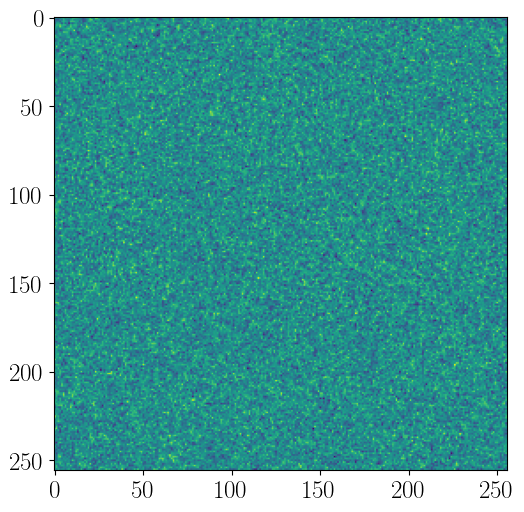

In [17]:
plt.imshow(downsampled_input_sfield[0,:,:])

In [8]:
mesh_input = ArrayMesh(input_sfield,BoxSize=Lbox)
r_input = FFTPower(mesh_input, mode='1d', dk=0.01, kmin=0.005)
Pk_input = r_input.power
for k in Pk_input.attrs:
    print("%s = %s" %(k, str(Pk_input.attrs[k])))

Nmesh = [512 512 512]
BoxSize = [2000. 2000. 2000.]
Lx = 2000.0
Ly = 2000.0
Lz = 2000.0
volume = 8000000000.0
mode = 1d
los = [0, 0, 1]
Nmu = 1
poles = []
dk = 0.01
kmin = 0.005
kmax = None
N1 = 0
N2 = 0
shotnoise = 0


/u/minh/conda-envs/jupyterlab-env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, '$k$')

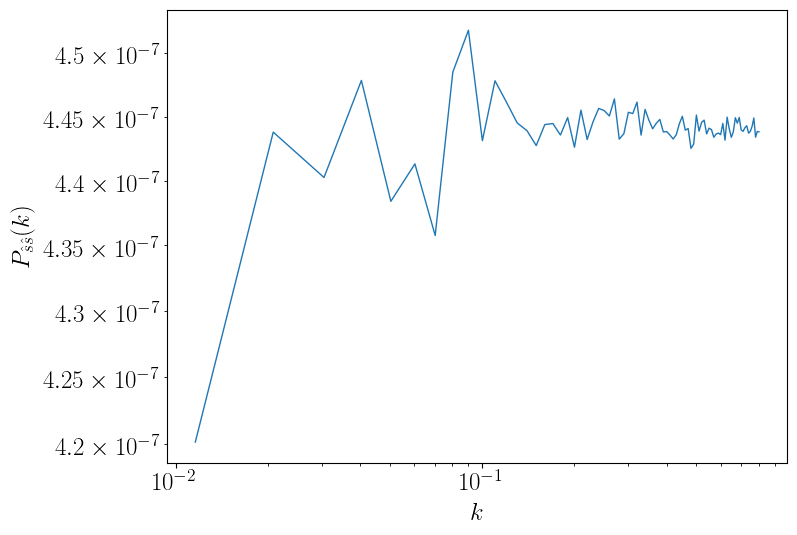

In [23]:
plt.loglog(Pk_input['k'],Pk_input['power'])
plt.ylabel(r'$P_{\hat{s}\hat{s}}(k)$')
plt.xlabel(r'$k$')

In [15]:
lefty_shat_file='/cobra/ptmp/minh/lefty_challenge/flatLCDM/box1/sampling_shat_bO/chain1/sampling_shat_bO_2lpt2d_FOURIER_NGEul192_L0.14_cube.stage1_1.h5'
with h5.File(lefty_shat_file,'r') as fhandle:
    lefty_shat_true=fhandle['shat_true'][()]
print(lefty_shat_true.shape)
print(lefty_shat_true.var())

OSError: Unable to open file (unable to open file: name = '/cobra/ptmp/minh/lefty_challenge/flatLCDM/box1/sampling_shat_bO/chain1/sampling_shat_bO_2lpt2d_FOURIER_NGEul192_L0.14_cube.stage1_1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

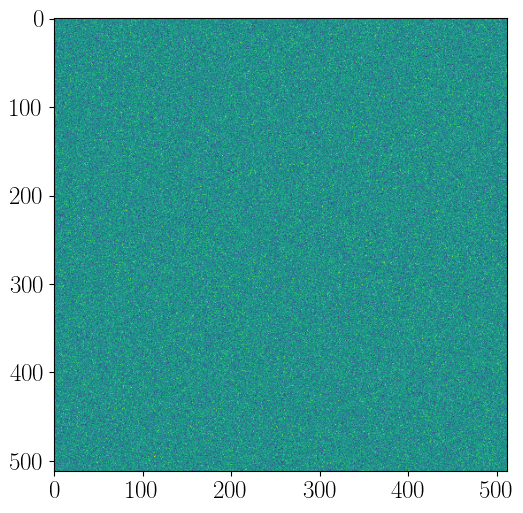

In [57]:
plt.imshow(input_shat_hartley[0,:,:])

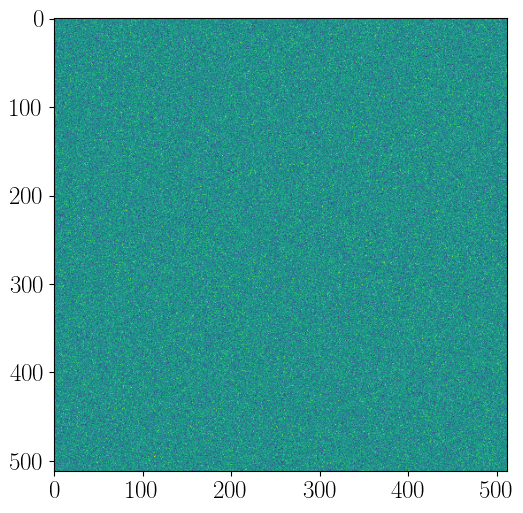

In [58]:
plt.imshow(lefty_shat_true[0,:,:])

In [ ]:
np.corrcoef(delta.flatten(),input_sfield.flatten())

## Get $P_{\mathrm{lin}}$ from CAMB to compare with the other two

In [8]:
redshift = 1.0
h=0.676225
Omega0_m=0.310240
Omega0_b=0.0222554/(h**2)
Omega0_ncdm=0.00064420/(h**2)
Omega0_cdm=Omega0_m-Omega0_b-Omega0_ncdm
print(Omega0_cdm*(h**2))
sigma8=0.85
n_s=0.991533
cosmo = cosmology.Cosmology(h=h,Omega0_cdm=Omega0_cdm,Omega0_b=Omega0_b,m_ncdm=[],As=2.1E-9,n_s=n_s)
Plin_CLASS = cosmology.LinearPower(cosmo, redshift, transfer='CLASS')
Pnonlin_Zeldovich = cosmology.ZeldovichPower(cosmo, redshift)
Pnonlin_HALOFIT = cosmology.HalofitPower(cosmo, redshift)

0.11896702495389998


/u/minh/conda-envs/jupyterlab-env/lib/python3.6/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): As
  self.engine = ClassEngine(pars)
/u/minh/conda-envs/jupyterlab-env/lib/python3.6/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "


## Plot power spectra

(0.01, 0.6)

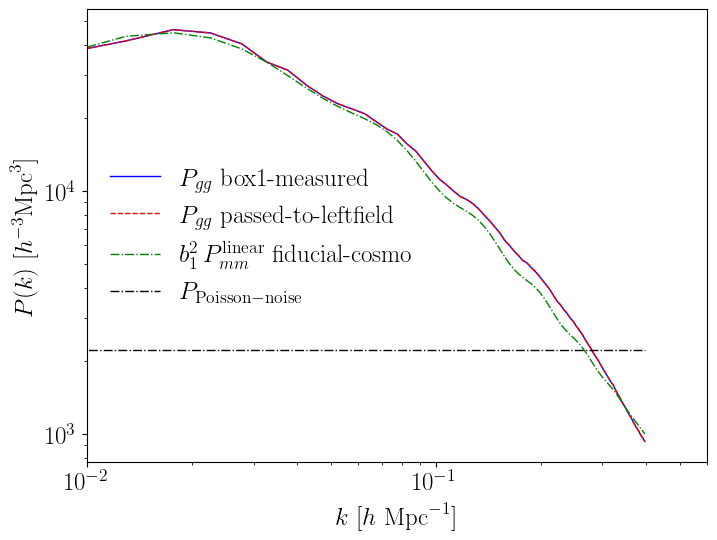

In [14]:
# print the shot noise subtracted P(k)
plt.loglog(Pk_origin['k'], Pk_origin['power'].real, c='b',label=r'$P_{gg}$ box1-measured')
plt.loglog(Pk_leftfield['k'],Pk_leftfield['power'].real,c='r',ls='--',label=r'$P_{gg}$ passed-to-leftfield')
plt.loglog(Pk_origin['k'],(2.18**2)*Plin_CLASS(Pk_origin['k']),c='green',ls='-.',label=r'$b_1^2\,P^{\mathrm{linear}}_{mm}$ fiducial-cosmo')
plt.loglog(Pk_origin['k'],np.ones_like(Pk_origin['k'])*((1./(4.5e-4))),c='k',ls='-.',label=r'$P_{\mathrm{Poisson-noise}}$')
#plt.loglog(Pk_origin['k'],Pnonlin_HALOFIT(Pk_origin['k']),c='violet',ls=':',label=r'$P_{mm}$ HALOFIT')

# format the axes
plt.legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.xlim(0.01, 0.6)

## Compute linear galaxy bias $b_1$

In [17]:
np.sqrt(Pk_leftfield['power'].real[Pk_leftfield['k']<0.02]/Plin_CLASS(Pk_origin['k'][Pk_leftfield['k']<0.02]))

array([2.18801449, 2.13198397, 2.20946977])